# Imports

In [1]:
from model_builder import ModelBuilder
from model_utils import *
import random
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import colorsys
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
plt.rcParams["font.family"] = "Times New Roman"
import warnings
warnings.filterwarnings("ignore")

In [2]:
with open("config.json", "rb") as json_file:
    config = json.load(json_file)
config

{'becker': {'filename': 'beckerestimation_output_conversation_level.csv',
  'cols_to_ignore': ['conversation_num',
   'mean_pre_discussion_error',
   'mean_post_discussion_error',
   'median_pre_discussion_error',
   'median_post_discussion_error',
   'median_pre_discussion_error_pct',
   'median_post_discussion_error_pct',
   'mean_pre_discussion_error_pct',
   'mean_post_discussion_error_pct',
   'reverse_mean_post_discussion_error_pct',
   'reverse_median_post_discussion_error_pct',
   'question',
   'chatrooms',
   'trial_indx']},
 'csop': {'filename': 'csop_output_conversation_level.csv',
  'cols_to_ignore': ['conversation_num',
   'batch_num',
   'round_num',
   'round_index',
   'task_index',
   'complexity',
   'type',
   'social_perceptiveness',
   'skill',
   'cogStyleDiversity',
   'skill_diversity',
   'normalized_score',
   'score',
   'duration',
   'efficiency']},
 'csopII': {'filename': 'csopII_output_conversation_level.csv',
  'cols_to_ignore': ['conversation_num',
   

In [3]:
def drop_invariant_columns(df):
    """
    Certain features are invariant throughout the training data (e.g., the entire column is 0 throughout).

    These feature obviously won't be very useful predictors, so we drop them.
    
    This function works by identifying columns that only have 1 unique value throughout the entire column,
    and then dropping them.

    @df: the dataframe containing the features (this should be X).
    """
    nunique = df.nunique()
    cols_to_drop = nunique[nunique == 1].index
    return(df.drop(cols_to_drop, axis=1))


In [4]:
def read_and_preprocess_data(path, min_num_chats):
    conv_data  = pd.read_csv(path)

    # Filter this down to teams that have at least min_num of chats
    # Can also comment this out to re-run results on *all* conversations!
    conv_data = conv_data[conv_data["sum_num_messages"] >= min_num_chats]


    # Save the important information

    # DV
    dvs = conv_data[["score","speed","efficiency","raw_duration_min","default_duration_min"]]

    # Team Composition
    composition_colnames = ['birth_year', 'CRT', 'income_max', 'income_min', 'IRCS_GS', 'IRCS_GV', 'IRCS_IB', 'IRCS_IR',
                'IRCS_IV', 'IRCS_RS', 'political_fiscal', 'political_social', 'RME', 'country', 'education_level',
                'gender', 'marital_status', 'political_party', 'race', 'playerCount']
    
    # Select columns that contain the specified keywords
    composition = conv_data[[col for col in conv_data.columns if any(keyword in col for keyword in composition_colnames)]]

    # Task
    task = conv_data[['task', 'complexity']].copy()

    task_map_path = '../utils/task_map.csv' # get task map
    task_map = pd.read_csv(task_map_path)

    task_name_mapping = {
        "Moral Reasoning": "Moral Reasoning (Disciplinary Action Case)",
        "Wolf Goat Cabbage": "Wolf, goat and cabbage transfer",
        "Guess the Correlation": "Guessing the correlation",
        "Writing Story": "Writing story",
        "Room Assignment": "Room assignment task",
        "Allocating Resources": "Allocating resources to programs",
        "Divergent Association": "Divergent Association Task",
        "Word Construction": "Word construction from a subset of letters",
        "Whac a Mole": "Whac-A-Mole"
    }
    task.loc[:, 'task'] = task['task'].replace(task_name_mapping)
    task = pd.merge(left=task, right=task_map, on = "task", how='left')
    
    # Create dummy columns for 'complexity'
    complexity_dummies = pd.get_dummies(task['complexity'])
    task = pd.concat([task, complexity_dummies], axis=1)   
    task.drop(['complexity', 'task'], axis=1, inplace=True)

    # Conversation
    conversation = conv_data.drop(columns=list(dvs.columns) + list(composition.columns) + ['task', 'complexity', 'stageId', 'roundId', 'cumulative_stageId', 'gameId', 'message', 'message_lower_with_punc', 'speaker_nickname', 'conversation_num', 'timestamp'])
    conversation = drop_invariant_columns(conversation) # drop invariant conv features

    return composition, task, conversation, dvs

In [5]:
min_num_chats = 0
data_path = "../output/"
tiny_multitask = 'conv/multi_task_TINY_output_conversation_level_stageId_cumulative.csv'
multitask_cumulative_by_stage = 'conv/multi_task_output_conversation_level_stageId_cumulative.csv'
multitask_cumulative_by_stage_and_task = 'conv/multi_task_output_conversation_level_stageId_cumulative_within_task.csv'

In [6]:
team_composition_features, task_features, conv_features, targets = read_and_preprocess_data(data_path + multitask_cumulative_by_stage, min_num_chats=min_num_chats)

In [7]:
tasks = pd.read_csv(data_path + multitask_cumulative_by_stage)["task"].to_frame().rename(columns={"task": "task_name"})

In [8]:
conv_plus_tasklabels = pd.concat([conv_features,tasks], axis = 1)

# PCA of Datasets

How do people "speak differently" across different tasks? Can we identify these different patterns of speaking just through clustering each conversation?

In [9]:
labels = list(tasks["task_name"].unique())

In [10]:
def split_dataframes(df):    
    grouped_df = df.groupby("task_name")
    return([group_df for group_name, group_df in grouped_df])

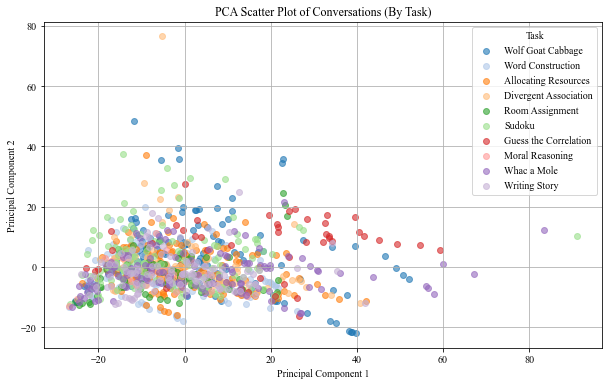

In [11]:
pca_results = plot_pca_of_dataframes(*split_dataframes(conv_plus_tasklabels), labels=labels, title = "PCA Scatter Plot of Conversations (By Task)")

In [12]:
pca_results.explained_variance_ratio_

array([0.22310849, 0.07124246])

In [13]:
examine_top_n_components(pca_results, n=10)

Top 5 Features for PC1:
                                               Feature       PC1       PC2  \
378                         average_user_sum_num_chars  0.060920 -0.009473   
374                         average_user_sum_num_words  0.060896 -0.013442   
574    average_user_sum_cognitive_mech_lexical_per_100  0.060762 -0.006423   
602  average_user_sum_nltk_english_stopwords_lexica...  0.060696 -0.009499   
555             average_user_sum_verbs_lexical_per_100  0.059901 -0.017163   
381                             max_user_sum_num_chars  0.059833 -0.011228   
377                             max_user_sum_num_words  0.059783 -0.016008   
605  max_user_sum_nltk_english_stopwords_lexical_pe...  0.059594 -0.013092   
577        max_user_sum_cognitive_mech_lexical_per_100  0.059516 -0.010813   
570   average_user_sum_auxiliary_verbs_lexical_per_100  0.059248 -0.015624   

      PC1_abs   PC2_abs  
378  0.060920  0.009473  
374  0.060896  0.013442  
574  0.060762  0.006423  
602  0.060696

,Feature,PC1,PC2,PC1_abs,PC2_abs
0,gini_coefficient_sum_num_words,0.003186,-0.002156,0.003186,0.002156
1,gini_coefficient_sum_num_chars,0.002070,-0.002037,0.002070,0.002037
2,gini_coefficient_sum_num_messages,0.008063,-0.009801,0.008063,0.009801
3,average_positive_bert,-0.008459,-0.038914,0.008459,0.038914
4,stdev_positive_bert,0.024208,-0.007236,0.024208,0.007236
...,...,...,...,...,...
1130,average_user_avg_certainty_rocklage,0.003503,-0.002647,0.003503,0.002647
1131,stdev_user_avg_certainty_rocklage,-0.012005,0.017966,0.012005,0.017966
1132,min_user_avg_certainty_rocklage,0.008682,-0.011498,0.008682,0.011498
1133,max_user_avg_certainty_rocklage,-0.003720,0.007020,0.003720,0.007020


PC 1 mostly captures *the quantity of how much people talk*.

## How much do all the other PC's tell us?
Answer: not a ton...

In [14]:
full_pca = get_pca_of_dataframes(split_dataframes(conv_plus_tasklabels), n_components = 10)

([<matplotlib.axis.XTick at 0x135371dc0>,
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9')])

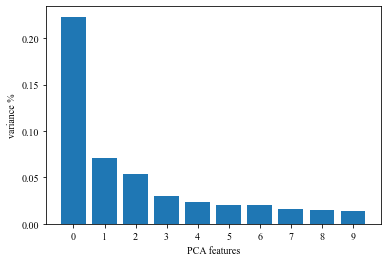

In [15]:
var = full_pca.explained_variance_ratio_
plt.bar(list(range(var.shape[0])),var)
feature = range(full_pca.n_components_)
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(feature)

# PCA of Features

Can we now model each feature as a point, and see how the different features relate to each other?

(The following code generates an interactive PCA plot, but opens in a brower window.)

Columns with NaN values: ['average_info_exchange_zscore_conversation', 'stdev_info_exchange_zscore_conversation', 'min_info_exchange_zscore_conversation', 'max_info_exchange_zscore_conversation', 'average_positivity_zscore_conversation', 'stdev_positivity_zscore_conversation', 'min_positivity_zscore_conversation', 'max_positivity_zscore_conversation', 'average_user_avg_info_exchange_zscore_conversation', 'stdev_user_avg_info_exchange_zscore_conversation', 'min_user_avg_info_exchange_zscore_conversation', 'max_user_avg_info_exchange_zscore_conversation', 'average_user_avg_positivity_zscore_conversation', 'stdev_user_avg_positivity_zscore_conversation', 'min_user_avg_positivity_zscore_conversation', 'max_user_avg_positivity_zscore_conversation']
Rows with NaN values: [61, 122, 127, 134, 146, 164, 168, 188, 209, 210, 222, 248, 271, 337, 368, 411, 463, 481, 675, 789, 829, 864, 865, 866, 867, 967]


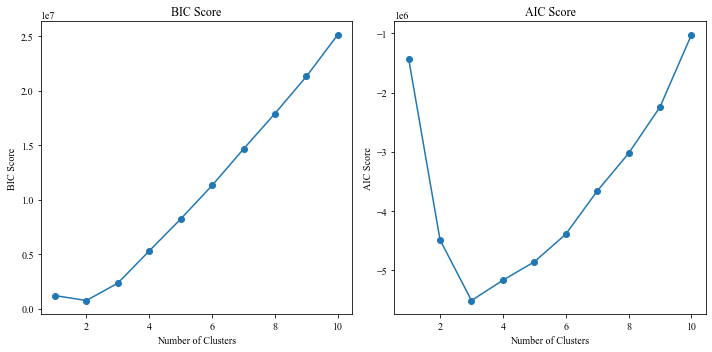

In [16]:
visualize_feature_clusters(split_dataframes(conv_plus_tasklabels), use_aic = True, title = "PCA Scatter Plot of Conversational Features")

Columns with NaN values: ['average_info_exchange_zscore_conversation', 'stdev_info_exchange_zscore_conversation', 'min_info_exchange_zscore_conversation', 'max_info_exchange_zscore_conversation', 'average_positivity_zscore_conversation', 'stdev_positivity_zscore_conversation', 'min_positivity_zscore_conversation', 'max_positivity_zscore_conversation', 'average_user_avg_info_exchange_zscore_conversation', 'stdev_user_avg_info_exchange_zscore_conversation', 'min_user_avg_info_exchange_zscore_conversation', 'max_user_avg_info_exchange_zscore_conversation', 'average_user_avg_positivity_zscore_conversation', 'stdev_user_avg_positivity_zscore_conversation', 'min_user_avg_positivity_zscore_conversation', 'max_user_avg_positivity_zscore_conversation']
Rows with NaN values: [61, 122, 127, 134, 146, 164, 168, 188, 209, 210, 222, 248, 271, 337, 368, 411, 463, 481, 675, 789, 829, 864, 865, 866, 867, 967]


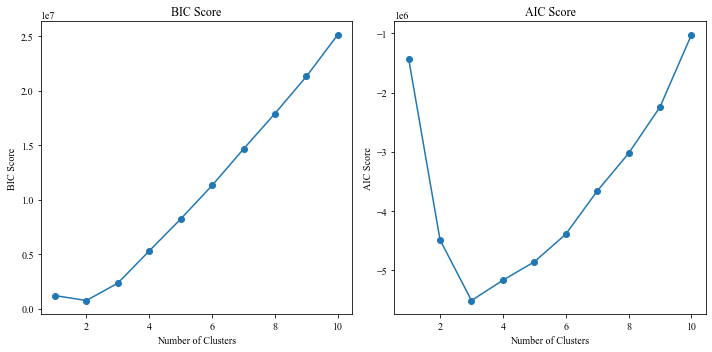

In [17]:
# Get more insight into the clusters!
all_data = pd.concat(split_dataframes(conv_plus_tasklabels), join = 'inner', ignore_index = True)

'''
The below reproduces the code from inside the plotting function, but gives us access to the actual cluster labels to 
play around with!
'''

# Normalize (Across all tasks)
columns_to_normalize = [col for col in all_data.columns if col != 'task_name']
normalized_df = all_data.copy()
normalized_df[columns_to_normalize] = normalized_df[columns_to_normalize].transform(lambda x: (x - x.mean()) / x.std())

# Drop NA columns
nan_cols, nan_rows = check_na_rows_cols(normalized_df)
normalized_df = normalized_df.drop(nan_cols, axis = 1)

normalized_data_transposed = normalized_df.drop(["task_name"], axis=1).T

# Get Clusters (using GMM) for the data, on the full-dimensional dataset.
cluster_labels = get_gaussian_mixture_clustering(normalized_data_transposed, use_aic=True)

In [18]:
normalized_data_transposed["cluster"] = cluster_labels

In [19]:
def explore_clustered_features(df, num_closest=5):
    unique_clusters = df['cluster'].unique()
    nearest_points_df = pd.DataFrame()

    for cluster_label in unique_clusters:
        cluster_data = df[df['cluster'] == cluster_label]
        features = cluster_data.drop(columns=['cluster'])

        centroid = features.mean(axis=0)
        similarity_scores = cosine_similarity([centroid], features).flatten()

        # Get the num_closest data points with highest similarity
        nearest_indices = np.argsort(similarity_scores)[-num_closest:]
        nearest_cluster_points = cluster_data.iloc[nearest_indices]
        nearest_points_df = pd.concat([nearest_points_df, nearest_cluster_points])

    return nearest_points_df

Explore the top n (=10) features per cluster, by examining the closest features to the cluster centroid. What is "most representative" of the cluster?

TODO: these clusters are not super interpretable...

In [20]:
top_10_features_per_cluster = explore_clustered_features(normalized_data_transposed, num_closest = 10)
pca = PCA(n_components=2)
pca_top = pca.fit_transform(top_10_features_per_cluster.drop(["cluster"], axis = 1))

# Create a new DataFrame with the PC scores and row names
pca_df = pd.DataFrame(data=pca_top, columns=["PC1", "PC2"], index=top_10_features_per_cluster.index)
pca_df["cluster"] = top_10_features_per_cluster["cluster"]

generate_interactive_feature_plot(pca_df, "PCA of Top 5 Features Per Cluster")

## PCA of User Features

In [21]:
users = pd.read_csv('../output/user/multi_task_output_user_level_stageId_cumulative.csv')

In [22]:
task_key = pd.read_csv(data_path + multitask_cumulative_by_stage)[["task", "conversation_num"]].rename(columns={"task": "task_name"})

In [23]:
user_df = users.merge(task_key, on="conversation_num", how = "left").drop(["conversation_num", "speaker_nickname", "user_list"], axis = 1)

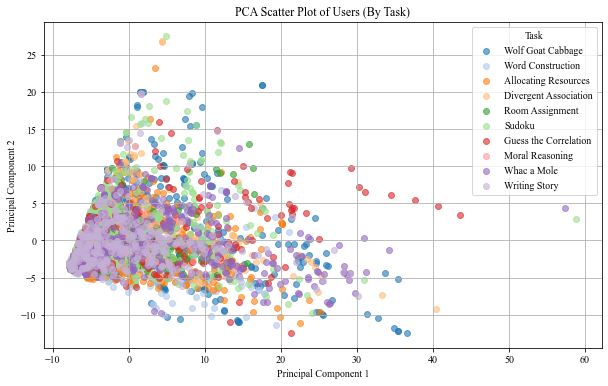

In [24]:
pca_results_users = plot_pca_of_dataframes(*split_dataframes(user_df), labels=labels, title = "PCA Scatter Plot of Users (By Task)")

In [25]:
pca_results_users.explained_variance_ratio_

array([0.27916954, 0.0833413 ])

In [26]:
examine_top_n_components(pca_results_users, n=10)

Top 5 Features for PC1:
                                        Feature       PC1       PC2   PC1_abs  \
100                               sum_num_words  0.132476 -0.031567  0.132476   
158  sum_nltk_english_stopwords_lexical_per_100  0.132018 -0.022023  0.132018   
151          sum_cognitive_mech_lexical_per_100  0.131839 -0.015443  0.131839   
101                               sum_num_chars  0.131775 -0.022861  0.131775   
146                   sum_verbs_lexical_per_100  0.130299 -0.035168  0.130299   
150         sum_auxiliary_verbs_lexical_per_100  0.127856 -0.031227  0.127856   
128           sum_present_tense_lexical_per_100  0.127584 -0.038788  0.127584   
108             sum_conjunction_lexical_per_100  0.125570 -0.008812  0.125570   
152             sum_preposition_lexical_per_100  0.125104 -0.000379  0.125104   
136      sum_indefinite_pronoun_lexical_per_100  0.123808 -0.036537  0.123808   

      PC2_abs  
100  0.031567  
158  0.022023  
151  0.015443  
101  0.022861  
146 

,Feature,PC1,PC2,PC1_abs,PC2_abs
0,average_positive_bert,-0.030376,-0.101838,0.030376,0.101838
1,average_negative_bert,0.038426,0.092925,0.038426,0.092925
2,average_neutral_bert,-0.003194,0.024418,0.003194,0.024418
3,average_num_words,0.073184,0.197883,0.073184,0.197883
4,average_num_chars,0.071970,0.194122,0.071970,0.194122
...,...,...,...,...,...
192,sum_hasnegative,0.112771,-0.023826,0.112771,0.023826
193,sum_subjunctive,0.003635,-0.004024,0.003635,0.004024
194,sum_indicative,0.024922,-0.012343,0.024922,0.012343
195,sum_forward_flow,0.108328,-0.112817,0.108328,0.112817
